In [1]:
import zipfile

In [2]:
# with zipfile.ZipFile('Flickr8k_Dataset.zip','r') as zip_ref:
#     zip_ref.extractall()

# with zipfile.ZipFile('Flickr8k_text.zip','r') as zip_ref:
#     zip_ref.extractall()

In [3]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.utils import load_img, img_to_array, pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
 
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

C:\Users\Abhay chandra\AppData\Local\Temp\ipykernel_4256\2556768508.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [4]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [5]:
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = list()
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions
     

In [6]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if(len(word)>1)]
            desc = [word for word in desc if(word.isalpha())]
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions
     

In [7]:
def text_vocabulary(descriptions):
    # build vocabulary 
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [8]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [9]:
dataset_images = "Flicker8k_Dataset"

filename = "Flickr8k.token.txt"
 
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

clean_descriptions = cleaning_text(descriptions)
  
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  7951


In [10]:
#EXTRACTING ALL IMAGES
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features


features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

C:\Users\Abhay chandra\AppData\Local\Temp\ipykernel_4256\478878335.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


In [11]:


features = load(open("features.p","rb"))

In [12]:
#Train the model
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [13]:
#Loading Descriptions

def load_clean_descriptions(filename, photos): 
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = ' ' + " ".join(image_caption) + ' '
            descriptions[image].append(desc)
    return descriptions
     

In [14]:
def load_features(photos):
    all_features = load(open("features.p","rb"))
    features = {k:all_features[k] for k in photos}
    return features

In [15]:
filename = "Flickr_8k.trainImages.txt"

train_imgs = load_photos(filename)

train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)

train_features = load_features(train_imgs)

In [16]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
 
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size
     


6889

In [17]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [18]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [19]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((24, 2048), (24, 32), (24, 6889))

In [20]:
#DEFINING CNN-RNN MODEL

from keras.utils import plot_model

def define_model(vocab_size, max_length):
    
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
   
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    #Decode outputs
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [21]:
#model definition
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 6889
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1763584     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']    

In [24]:
#model training
epochs = 10
steps = len(train_descriptions)

os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= 1000, verbose=1)

model.save("Image_captioning_model.h5")

C:\Users\Abhay chandra\AppData\Local\Temp\ipykernel_4256\92064946.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= 1000, verbose=1)


1000/1000 [==============================] - 217s 217ms/step - loss: 2.1716


In [43]:
#TESTING THE MODEL
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_path = "Flicker8k_Dataset/406642021_9ec852eccf.jpg" # enter image path here

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature


In [44]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


1/1 [==============================] - 1s 912ms/step



formation repelling over the side of mountain formation formation set over the man without helmet is going over the formation behind them is rest over the giant supported of the giant co


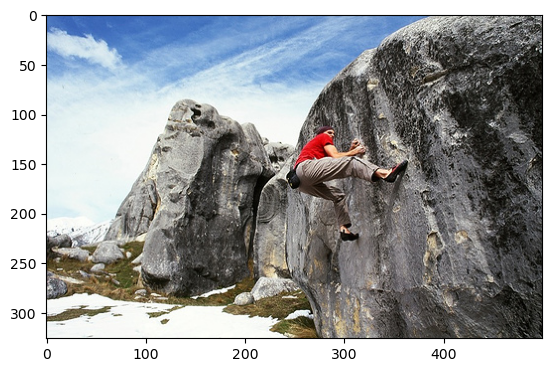

In [45]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))

model = load_model('Image_captioning_model.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)

img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
description=description[6:-3] # removing start and end.
print("\n\n")
print(description)
plt.imshow(img)

In [51]:
img_path = "Flicker8k_Dataset/410422753_de506155fa.jpg" # enter image path here

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature


In [52]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


1/1 [==============================] - 1s 865ms/step



dog is playing in the snow of snow and yellow ball in the background and large snow in the background is standing in the background and brown jacket is standing in 


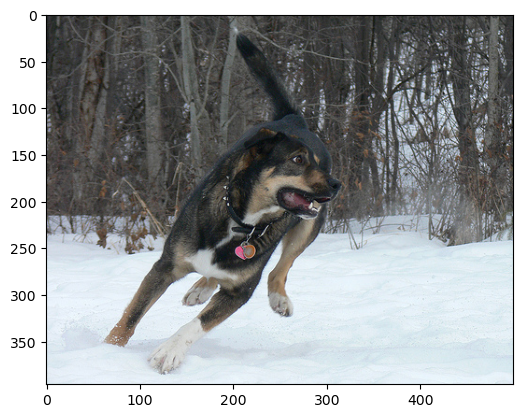

In [53]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))

model = load_model('Image_captioning_model.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)

img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
description=description[6:-3] # removing start and end.
print("\n\n")
print(description)
plt.imshow(img)